# An Object Oriented Metropolis Hastings

In [24]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform, multivariate_normal
import corner.corner
import sys

## The Sampler

I define the sampler below. It uses the Metropolis Hastings algorithm, but uses the slightly modified log version of the acceptance criterion, in which 

$$
\ln r = \ln U(0,1)
$$

and the ratio comparison asks whether 

$$
\ln r < \ln f_{0} - \ln f_{p}
$$

where $f_{0}$ is the value of the target pdf at the current theta, and $f_{p}$ is the value of the target pdf at the proposed theta.

In [47]:
class MetropolisHastings():
    def __init__(self):
        '''
        Metropolis Hastings class. Allows the user to input target and proposal pdfs, and run the sampler. Has convenience functions for
        visualizing results. 
        '''
        self.u = uniform()
    def set_target_pdf(self,pdf_handle):
        '''
        Sets the target distribution to sample from.
        
        Parameters
        ----------
        pdf_handle: func
            function to sample from. Values of theta will be input, and the outputs will be compared in the chain. 
        Returns
        ------
        None
        '''
        self.pdf = pdf_handle
    def set_proposal(self,proposal_handle,**kwargs):
        '''
        Sets the proposal pdf to use when selecting new theta positions. 
        
        Parameters
        ----------
        proposal_handle: func 
            function to draw proposal values from. 
        **kwargs
            any additional arguments needed to run the proposal function 
            
        Returns
        -------
        None
        '''
        self.proposal = proposal_handle
        self.proposal_kwargs = kwargs
        
    def sample(self,nsteps,init):
        '''
        Run the sampler. 
        
        Parameters
        ----------
        nsteps: int
            Number of iterations to run the sampler. Will equal the length of the chain. 
        init: array_like 
            Initial value(s) to use. Depending on the target pdf, could be multidimensional. 
        Sets
        ----
        posterior: array_like
            The chain containing theta positions accepted in the chain. 
        n_accepted: int
            The number of proposals accepted (vs retaining the same theta)
            
        Returns
        -------
        None
        '''
        self.nsteps = nsteps
        self.theta_init = init
        self.posterior = []
        theta = self.theta_init # start at init
        steps = 0
        self.n_accepted = 0
        self.autocorr_length = []
        for i in range(self.nsteps):
            completeness = ((steps+1) / self.nsteps)*100.00
            sys.stdout.flush()
            sys.stdout.write('Sampling.... {:.1f}% complete. \r'.format(completeness))
            steps+=1
            current_likelihood = self.pdf(theta)
            proposed_theta = self.proposal(theta,**self.proposal_kwargs)
            proposed_likelihood = self.pdf(proposed_theta)
            lnr = np.log(self.u.rvs()) # should always be positive so no issue
            ln_prop = np.log(proposed_likelihood)
            if np.isnan(ln_prop):
                ln_prop = -np.inf
            alpha = ln_prop - np.log(current_likelihood) 
            # the current likelihood (from prev step) should've been checked for compliance
            if alpha > lnr:
                theta = proposed_theta
                self.posterior.append(theta)
                self.n_accepted+=1
                
            else:
                self.posterior.append(theta)
            #self.autocorr_length.append(autocorr(np.array(self.posterior)))
        self.posterior = np.array(self.posterior)
    
    def plot_corner(self):
        '''
        Convenience function for plotting a corner plot of the posterior
        '''
        fig = corner.corner(self.posterior)
    def plot_chain(self):
        '''
        Convenience function for plotting the chains
        '''
        n = len(self.theta_init)
        fig, ax = plt.subplots(n,1,figsize=(12,n*2))
        for i in range(n):
            ax[i].plot(self.posterior[:,i])

## Creating a target and proposal pdf

Below, I create a target distribution using `scipy` which for an input $x$, runs the `.pdf()` method to evaluate the created multivariate object at that location. Note that `input_pdf()` can be anything, so long as it takes the inputs generated and returns an output. 

I also establish the proposal distribution, which in this case will be a multivariate normal centered on some theta (wherever we are in the chain). I've decided here to define sigma (i.e., a symmetric gaussian ball in all dimensions), which gets turned into a covariance by multiplying sigma squared by an identity matrix whose size is defined by how ever long theta is.

In [48]:
def input_pdf(x):
    return multivariate_normal(cov=np.array([[2.0,1.2],[1.2,2.0]])).pdf(x)

def multivariate_proposal(theta,sigma=1):
    '''
    A Gaussian proposal function which works on an N-dimensional theta vector.
    Arbitrarily allows sigma to be a constant, or rank N for each direction in parameter space
    '''
    sigma = np.array(sigma)
    theta = np.array(theta)
    return multivariate_normal(mean = theta, cov = sigma**2*np.identity(len(theta))).rvs()

## Visualizing the target PDF 

In this example, our function is easy to visualize because we've made it an analytic gaussian function. But it could be anything. In this case, I create a meshgrid, and evaluate the function at the grid positions, contouring it. 

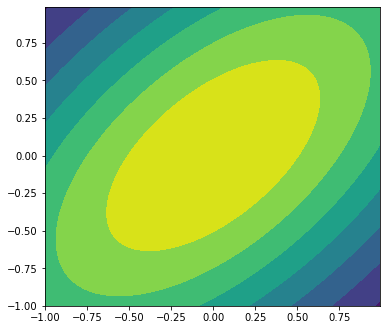

In [16]:
fig, ax = plt.subplots(figsize=(6,5.5))
x, y = np.mgrid[-1:1:.01, -1:1:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
ax.contourf(x, y, input_pdf(pos))

## Running the Sampler 

Below, I set up my sampler and run it. The simplicity and readabiity of the following lines motivates why we (sometimes) take the time to complete the boilerplate involved with writing a class.

In [49]:
sampler = MetropolisHastings()
sampler.set_target_pdf(input_pdf)
sampler.set_proposal(multivariate_proposal)
sampler.sample(nsteps=10000,init=[5,5])


### Visualizing the Results

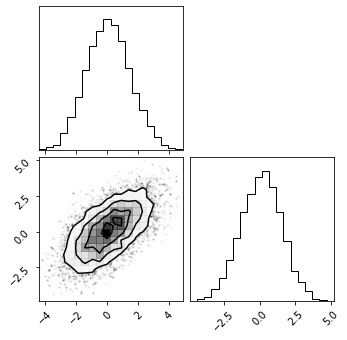

In [50]:
p = sampler.posterior
fig = corner.corner(p);

We can see that our sampler recovered the target distribution in these two parameters. If we had no clue what the shape of our target distribution was, our sampler would've explored it and figured it out. We can read off the parameter uncertainties from the 1D histogram, or by calculating percentiles:

In [51]:
np.percentile(p,[16,50,84],axis=0).T

array([[-1.35598574,  0.07823572,  1.51543468],
       [-1.36190128,  0.12697103,  1.51196126]])

And lastly, we can look at the chains directly. We can seee that because I started with a `theta_init` of (5,5), it took our sampler a few tens of iterations to work its way to the max likelihood region of (0,0), but then it stays there. We might throw the first few hundred samples out when calculating statistics like the percentile above just to be sure. 

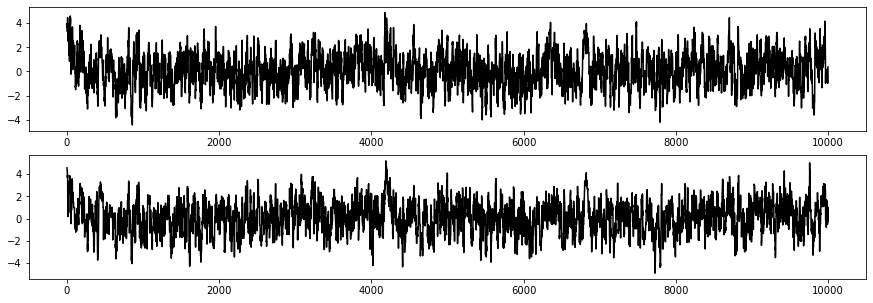

In [52]:
fig, ax = plt.subplots(2,1,figsize=(15,5))
ax[0].plot(p[:,0],'k')
ax[1].plot(p[:,1],'k')